## Data Dictionary

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 0.0 Imports 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from datetime import datetime, timedelta

import seaborn as sns

from IPython.display import Image

In [2]:
# Set the style
sns.set_style('darkgrid')

# Set to display an unlimited number of columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None


### 0.1 Helper Functions

In [3]:

def camel_to_snake(s):
    # Function that converts camel style to snake style
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [4]:
def descriptive_analysis(numerical_df):
    # Function that calculate all the statistics measures for the dataset
    # Central tendency - Mean, median
    ct1 = pd.DataFrame(numerical_df.apply(np.mean)).T
    ct2 = pd.DataFrame(numerical_df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(numerical_df.apply(np.std)).T
    d2 = pd.DataFrame(numerical_df.apply(min)).T
    d3 = pd.DataFrame(numerical_df.apply(max)).T
    d4 = pd.DataFrame(numerical_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(numerical_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(numerical_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
    m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

    return m

### 0.2 Loading Data

In [5]:
# Read CSV
df0 = pd.read_csv('../data/historical_data.csv',low_memory=True)

In [6]:
# Display the first 5 rows
df0.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1.0 Data Description

This section give to you the understanding of the dataset, through the features it has.

In [7]:
df1 = df0.copy()

In [8]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### 1.1 Rename Columns

In [9]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
           'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
           'isFlaggedFraud']

snake_case = lambda x: camel_to_snake(x)

cols_new = list(map(snake_case, cols_old))

df1.columns = cols_new

In [10]:
df1.rename(columns = {'oldbalance_org' : 'oldbalance_orig'}, inplace = True)

### 1.2 Data Dimensions

In [11]:
print("Number of examples:", df1.shape[0])
print("Number of features:", df1.shape[1])

Number of examples: 6362620
Number of features: 11


### 1.3 Data Type

In [12]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_orig     float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

### 1.4 Checking Missing Values

In [13]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_orig     0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

The dataset does not have missing values.

### 1.5 Descriptive Statistics

#### 1.5.1 Numerical Attributes

In [14]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

In [15]:
desc_analysis = descriptive_analysis(num_attributes)
desc_analysis

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,step,2.433972e+02,239.000,1.423320e+02,1.0,7.430000e+02,7.420000e+02,0.375177,0.329071
1,amount,1.798619e+05,74871.940,6.038582e+05,0.0,9.244552e+07,9.244552e+07,30.993949,1797.956705
2,oldbalance_orig,8.338831e+05,14208.000,2.888242e+06,0.0,5.958504e+07,5.958504e+07,5.249136,32.964879
3,newbalance_orig,8.551137e+05,0.000,2.924048e+06,0.0,4.958504e+07,4.958504e+07,5.176884,32.066985
4,oldbalance_dest,1.100702e+06,132705.665,3.399180e+06,0.0,3.560159e+08,3.560159e+08,19.921758,948.674125
5,newbalance_dest,1.224996e+06,214661.440,3.674129e+06,0.0,3.561793e+08,3.561793e+08,19.352302,862.156508
6,is_fraud,1.290820e-03,0.000,3.590479e-02,0.0,1.000000e+00,1.000000e+00,27.779538,769.702982
7,is_flagged_fraud,2.514687e-06,0.000,1.585775e-03,0.0,1.000000e+00,1.000000e+00,630.603629,397659.062500


- **step** has 743 hours of simulation;
- The variable **amount, oldbalance_orig, new_balance_orig, oldbalance_dest, new_balance_dest** are very skewd and have a lot of kurtosis, it indicates that does not follow a normal distribution;
- Median of the variables mentioned above can represent better the central tendency;
- **is_fraud** and **is_flagged_fraud** are binary variables;

#### 1.5.2 Categorical Attributes

In [16]:
cat_attributes.nunique()

type               5
name_orig    6353307
name_dest    2722362
dtype: int64

- 6.35kk of unique people started a transaction and 2.72kk of unique people received a transaction.

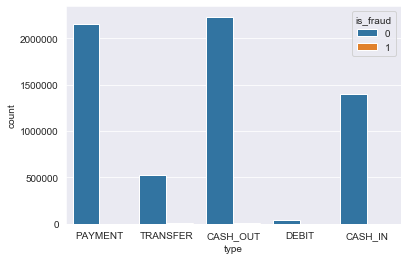

In [17]:
sns.countplot(x = 'type', hue = 'is_fraud', data = df1)

- It is impossible to analyze NOW the impact of **is_fraud** in variable **type** due to dataset imbalance;
- The most common form of transaction is **cash_out**, followed by **payment** and **cash_in**. 

## 2.0 Feature Engineering

The section of Feature Engineering involves leveraging data mining techniques to extract features from raw data along with the use of domain knowledge. This may be useful to improve the performance of machine learning algorithms and also to get experience about the business model in order to generate new insights.

In [118]:
df2 = df1.copy()

### 2.1 Hypothesis Mind Map

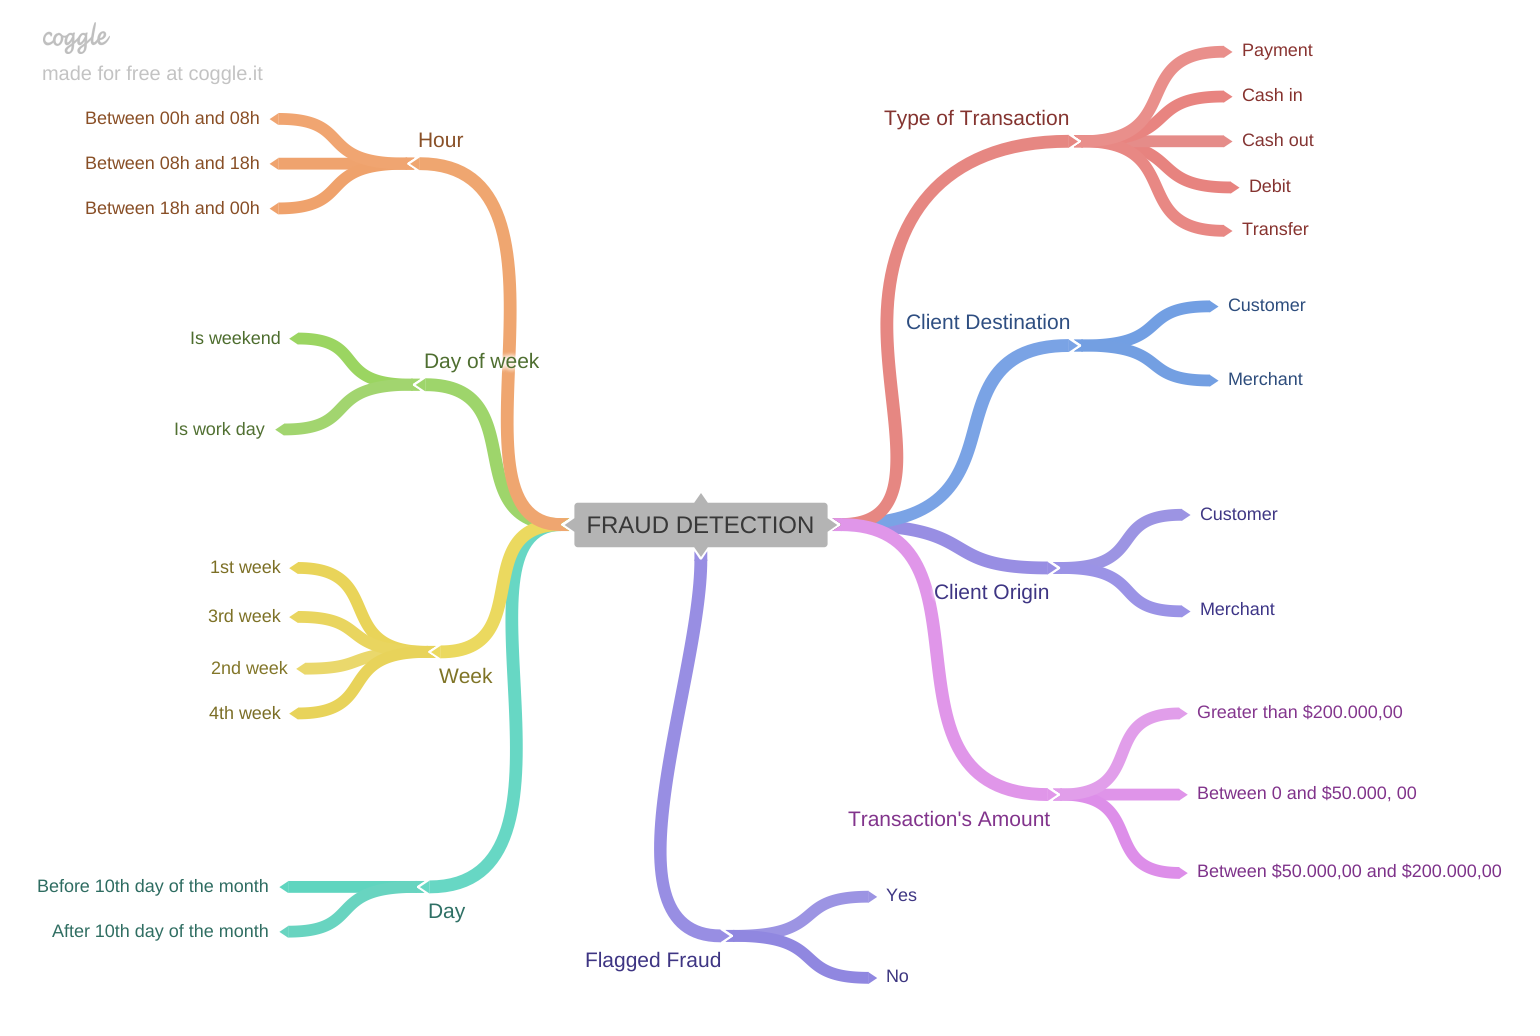

In [19]:
Image('../images/mind_map_fraud.png')

### 2.2 Hypothesis List

**H1** - Transactions classified as payment is more likely to be fraud;

**H2** - The amount of money of fraudulent transactions classified as transfer is greater than else.

**H3** - Customer-customer transactions tend to be more fraudulent than Customer-Merchant.

**H4** - Transactions over \\$200.000,00 are always fraudulent.

**H5** - Transactions between 0 and \\$50.000,00 are more likely to be fraud than those between \\$50.000,00 and \\$200.000,00.

**H6** - Transactions before the 10th day of the month are more likely to be fraud.

**H7** - The first week of the month are more likely to be fraud.

**H8** - Transactions during the work day are more likely to be fraud.

**H9** - Transactions after 18h are more likely to be fraud.

**H10** - When the transaction reach oldbalance_old equal zero, it is more likely to be fraud;

**H11** - When the transaction has an amount greater than oldbalance_old, it is more likely to be fraud;

Since it is a simulation of 30 days, I am going to consider it from a specific time in the beginning of the month. 

In [112]:
# Function that calculates the error after a transaction in the origin side
def error_after_transaction_orig(transaction_type, old, new, amount):
    if transaction_type == 'CASH_IN':
        return old + amount - new
    elif transaction_type == 'CASH_OUT':
        return old - amount - new
    elif transaction_type == 'DEBIT':
        return old - amount - new
    elif transaction_type == 'PAYMENT':
        return old - amount - new
        
    else:
        return old - amount - new

In [111]:
# Function that calculates the error after a transaction in the destination side
# NEW and OLD balance for Merchants are always 0
def error_after_transaction_dest(transaction_type, old, new, amount):
    if transaction_type == 'CASH_IN':
        return old - amount - new
    elif transaction_type == 'CASH_OUT':
        return old + amount - new
    elif transaction_type == 'DEBIT':
        return old + amount - new
    elif transaction_type == 'PAYMENT':
        return 0 
        
    else:
        return old + amount - new

In [120]:
#  Stratifying the transaction's amount 
df2['amount_group'] = df2['amount'].apply(lambda x: 0 if x < 50000 else 1 if (x >=50000) & (x < 200000) else 2)

# Since it is a simulation, I'm going to consider it started in 01/09/2015 00:00:00 and each step is one hour
df2['date'] = df2['step'].apply(lambda x:  datetime(2015, 9, 1, 00, 00, 00) + timedelta(hours=x))

# Extract day
df2['day'] = df2['date'].dt.day

# Extract day of week
df2['day_of_week'] = df2['date'].dt.dayofweek

# Extract hour
df2['hour'] = df2['date'].dt.hour

# The error after the transaction is calculated based on type of transaction, this can help the model to find when the money didn't add or subtract from the bank account
df2['error_after_tran_orig'] = df2.apply(lambda x: error_after_transaction_orig(x['type'], x['oldbalance_orig'], x['newbalance_orig'], x['amount']), axis = 1)

# The error after the transaction is calculated based on type of transaction, this can help the model to find when the money didn't add or subtract from the bank account
df2['error_after_tran_dest'] = df2.apply(lambda x: error_after_transaction_dest(x['type'], x['oldbalance_dest'], x['newbalance_dest'], x['amount']), axis = 1)

# Define if a client of origin is a Customer or a Merchant
df2['client_origin'] = df2['name_orig'].apply(lambda x: 'Customer' if 'C' in x else 'Merchant')

# Define if a client of destination is a Customer or a Merchant
df2['client_destination'] = df2['name_dest'].apply(lambda x: 'Customer' if 'C' in x else 'Merchant')


In [121]:
df2.sample()

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,amount_group,date,day,day_of_week,hour,error_after_tran_orig,error_after_tran_dest,Client Origin,Client Destination
3162594,237,CASH_OUT,50826.93,C302811812,106107.0,55280.07,C1701197001,26311.57,77138.5,0,0,1,2015-09-10 21:00:00,10,3,21,0.0,0.0,Customer,Customer


## 3.0 Data Filtering

In [127]:
df3 = df2.copy()

In [128]:
cols_to_drop = ['step', 'name_orig', 'name_dest']
df3 = df3.drop(cols_to_drop, axis = 1)

- I've dropped the **step** column due to creation of a date column;
- I've dropped **name_orig** and **name_dest** because I don't believe there are more informations than Customer and Merchant in this moment.

## 3.0 Exploratory Data Analysis

## 4.0 Data Preparation

## 5.0 Machine Learning Models

## 6.0 Performance